# Training a self-driving car agent
## Reinforcement Learning Project
This documentation outlines the thought process behind training a smartcab to navigate on its own. We're applying reinforcement learning techniques for a self-driving agent in a simplified world to aid it in effectively reaching its destinations in the allotted time. 

First we'll investigate the given environment in which the agent operates in and instruct it, to execute very basic driving commands. Afterwards we'll exhibit the different states a smartcab can be in, analyzing its limited world and derive a Q-Learning algorithm, that will guide the agent towards its destination. At last we'll be going through several iterations in order to find the best configuration for our algorithm and the environment its operating in, to improve the results.

## Description
In the not-so-distant future, taxicab companies across the United States no longer employ human drivers to operate their fleet of vehicles. Instead, the taxicabs are operated by self-driving agents — known as smartcabs — to transport people from one location to another within the cities those companies operate. In major metropolitan areas, such as Chicago, New York City, and San Francisco, an increasing number of people have come to rely on smartcabs to get to where they need to go as safely and efficiently as possible. Although smartcabs have become the transport of choice, concerns have arose that a self-driving agent might not be as safe or efficient as human drivers, particularly when considering city traffic lights and other vehicles. To alleviate these concerns, your task as an employee for a national taxicab company is to use reinforcement learning techniques to construct a demonstration of a smartcab operating in real-time to prove that both safety and efficiency can be achieved.

## Software Requirements
This project uses the following software and Python libraries:

* [Python 2.7](https://www.python.org/download/releases/2.7/)
* [NumPy](http://www.numpy.org/)
* [PyGame](http://pygame.org/)
    * **Helpful links for installing PyGame:**
    * [Getting Started](https://www.pygame.org/wiki/GettingStarted)
    * [PyGame Information](http://www.pygame.org/wiki/info)
    * [Google Group](https://groups.google.com/forum/#!forum/pygame-mirror-on-google-groups)
    * [PyGame subreddit](https://www.reddit.com/r/pygame/)
    
## Definitions

### Environment
The smartcab operates in an ideal, simplified, grid-like city (see image below). Roads are established on two major axis (North-South & East-West). There are other vehicles on the road but the city is abstracted to a point where there are no other obstacles such as traffic jams, construction sights or other heterogenous agents such as pedestrians. However there are certain rules the city runs on, which are alike to our street system. At each intersection there is a traffic light that either allows traffic in the North-South direction or the East-West direction.

![Smart Cab Environment](smartcab_screenshot.png)

**Following rules guide the traffic:**
* On a green light, a left turn is permitted if there is no oncoming traffic making a right turn or coming straight through the intersection.
* On a red light, a right turn is permitted if no oncoming traffic is approaching from your left through the intersection.

### Inputs and Outputs
Very much alike to modern hail-a-cab applications the smartcab will have a route assigned based on t he passengers' starting location and the destination. The route is split at each intersection into waypoints, and for simplicity purposes the the smartcab is at some intersection at any instant in the world. 

Therefore, the next waypoint to the destination, assuming the destination has not already been reached, is one intersection away in one direction (North, South, East, or West). 

### States
The smartcab has only an egocentric view of the intersection it is at and can therefore use following information: 

* The state of the traffic light for its direction of movement: `['green', 'red']`
* Whether there is a vehicle at the intersection for each of the oncoming directions: `['left', 'right', 'oncoming']`

### Actions
For each action, the smartcab has one of the following options:

* Idle at the intersection
* Drive to the next intersection to either of the directions, which offers a set of following actions: `[None, 'left', 'right', 'forward']`

### Deadline
The smartcab has to get to its final destination in a given time. With each action taken, this time decreases. If the allotted time becomes zero before reaching the destination, the trip has failed.

### Rewards, Penalties and Goal
Smartcabs receive rewards for each successfully completed trip and smaller rewards for each action they execute successfully that obeys traffic rules. For any incorrect action a small penalty will be given and violating traffic rules or causing traffic accidents result in a high penalty. Based on the rewards and penalties the smartcab receives, the self-driving agent implementation will learn an optimal policy for driving on the city roads while obeying traffic rules, avoiding accidents, and reaching passengers' destinations in the allotted time.

## Implementing a Basic Driving Agent
In order to get going, we'll implement a basic driving agent that chooses from all possible actions one at random and drives through the city streets. 
In order to do so, we set `enforce_deadline` to `False` on line `47` and implement the following code in `agent.py` on line `30`:

In [1]:
# Pick a random action from set of possible actions. 
import random
action = random.choice([None, 'forward', 'left', 'right'])

In [2]:
# Quick code to demonstrate effect of actions allocation. 
n = 5
action_dict = []
for _ in range(n):
    action_dict.append(random.choice([None, 'forward', 'left', 'right']))
print "Smartcab performs following", n, "actions:", action_dict

Smartcab performs following 5 actions: ['left', 'right', 'right', None, 'right']


In order to make the observations countable we're implementing a code that counts each state where `deadline == 0` and `reward < 8` as not successful and states in which `reward >= 8` as successful attempts. We're choosing `8` as a reward boundary in order to account for possible negative rewards that are possible on the last attempt to get to the goal. For example if the car gets into an accident while going on the last field. Following code simulates this process:

In [3]:
import pandas as pd
import numpy as np
from smartcab.rl_stats import draw_sigmoid, plot_ts

# Create dict for trial summary
trial_summary = {}
# Initiate two states (0 = not successful, 1 = successful)
for i in range(2):
    trial_summary[i] = 0

for i in range(100):
    # Initiate dummy variables
    deadline = 0
    reward = 0
    
    # Simulates 10% of attempts being successful
    if (i % 10 == 0):
        deadline = 1
        reward = 8
    if (deadline == 0) & (reward < 8):
        trial_summary[0] += 1
    elif (reward >= 8):
        trial_summary[1] += 1

success_summary = pd.DataFrame.from_dict(trial_summary, orient='index')
success_summary.columns = ['trial_count']
success_summary.index = ['no_success', 'success']
success_summary

,trial_count
no_success,90
success,10


As mentioned we'll implement a loop that executes the trials n-times, store the results in a table and takes the average over all n attempts for better comparision.

`basic_agent.py` looks like follows:

```python
import pandas as pd
import random
from collections import Counter
from environment import Agent, Environment
from planner import RoutePlanner
from simulator import Simulator

class LearningAgent(Agent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(LearningAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.color = 'taxi'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.trial_count = 0
        self.trial_summary = {}
        for i in range(2):
            self.trial_summary[i] = 0

    def reset(self, destination=None):
        self.planner.route_to(destination)
        # TODO: Prepare for a new trip; reset any variables here, if required
        self.trial_count = 0
        #self.trial_summary[0] = 0
        #self.trial_summary[1] = 0

    def update(self, t):
        # Gather inputs
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        deadline = self.env.get_deadline(self)

        # TODO: Update state
        
        # TODO: Select action according to your policy
        action = random.choice([None, 'forward', 'left', 'right'])

        # Execute action and get reward
        reward = self.env.act(self, action)

        # TODO: Learn policy based on state, action, reward

        print "LearningAgent.update(): deadline = {}, inputs = {}, action = {}, reward = {}".format(
            deadline, inputs, action, reward)  # [debug]

        if (deadline == 0) & (reward < 8):
            self.trial_summary[0] += 1
            print "#" * 20
            print "Trial was unsuccessful."
            print "#" * 20
        else:
            if (reward >= 8):
                self.trial_summary[1] += 1
                print "#" * 20
                print "Trial was successful."
                print "#" * 20

def run():
    """Run the agent for a finite number of trials."""

    # Set up environment and agent
    e = Environment()  # create environment (also adds some dummy traffic)
    a = e.create_agent(LearningAgent)  # create agent
    e.set_primary_agent(a, enforce_deadline=False)  # specify agent to track
    # NOTE: You can set enforce_deadline=False while debugging to allow longer trials

    # Now simulate it
    # create simulator (uses pygame when display=True, if available)
    sim = Simulator(e, update_delay=0, display=False)  
    # NOTE: To speed up simulation, reduce update_delay and/or set display=False

    success_summary = pd.DataFrame(index = ['no_success', 'success'])
    validation_no = 10

    for i in range(validation_no):
        sim.run(n_trials=100)  # run for a specified number of trials
        # NOTE: To quit midway, press Esc or close pygame window, or hit Ctrl+C on the command-line
        print "Trial Count: ", a.trial_count
        success_temp = pd.DataFrame.from_dict(a.trial_summary, orient='index')
        success_temp.index = ['no_success', 'success']
        temp_column_name = 'trial_count_' + str(i+1)
        #success_temp.columns = [temp_column_name]
        success_summary[temp_column_name] = success_temp
        a.trial_summary[0] = 0
        a.trial_summary[1] = 0
    #print "Arrived", Counter(a.trial_summary.values()).most_common()[1][1], "times."
    print success_summary
    success_average = success_summary.mean(axis=1)
    print "Average: "
    print success_average
    print "Percentage: ", success_average[0:][1] / success_average[0:][0] 

if __name__ == '__main__':
    run()
```

### Observations
> There are a couple interesting observations when you run the smartcab with nothing but random actions:

> * When crashing, cars will restart at a different location and start to perform actions again.
> * There are 3 other agents or cars in play.
> * With n $\rightarrow \infty$ (through `enforce_deadline = False`) the agent reaches the goal eventually if it doesn't crash into another vehicle.
> * There is a reward system in place that shows the immediate gratification of an action.

> When we set `enforce_deadline` to `False` and let it run 10 times with `n_trials = 100` we get following averaging stats:

> |               | trial_count   |
> | ------------- | ------------- |
> | no_success    | 79.5          |
> | success       | 20.5          |

> Which indicates that only 25.78 % of all agents reach their destination in the given time. Not very convenient for our passengers. This is the measure we would like to improve significantly down the road. 

>> The data corresponding to this claim can be found in the file: `data/basic_agent_trials.csv`

We'll use this metric as one of our baselines for our next implementations.

In [11]:
basic_agent_trials = pd.read_csv('data/basic_agent_trials.csv', index_col=0)
basic_agent_trials

,trial_count_1,trial_count_2,trial_count_3,trial_count_4,trial_count_5,trial_count_6,trial_count_7,trial_count_8,trial_count_9,trial_count_10
no_success,73,79,76,78,80,87,77,82,77,86
success,27,21,24,22,20,13,23,18,23,14


In [12]:
basic_agent_trials.mean(axis=1)

no_success    79.5
success       20.5
dtype: float64

### Inform the Driving Agent
Now that the driving agent is capable of moving around in the environment, the next task is to identify a set of states that are appropriate for modeling the smartcab and environment. 

The main source of state variables are the current inputs at the intersection, but given our set of rules not all may require representation. The goal is, to process the inputs and update the agent's current state at each waypoint using the `self.state` variable. In order to check our performance we'll continue with the simulation deadline enforcement `enforce_deadline` being set to `False`.

#### All information available
Let's take a look at all information we've got available in our environment and talk through the possibilities that come with each of these inputs.

##### Traffic Lights
As mentioned above, we have an indicator that shows what color the traffic light at any given position of the agent has. This can take the values `green` and `red`. We find this information in the inputs dictionary and can call it with `inputs['light']`. Given our set of rules, this is a highly useful indicator for our smartcab to decide whether it should perform a certain action or not. This information will be included in our set of state variables.

```python
`inputs['light'] = ['red', 'green']`
```

##### Traffic
Our agent can detect, whether there is a vehicle at the intersection for each of the oncoming directions and what action this other agent is performing. Given the set of rules that apply on US streets we have following information that we need to especially emphasize:

* If the traffic light is green:
    * Is there oncoming traffic going in my direction? ($\rightarrow$ can't perform a left turn)
* If the traffic light is red:
    * Is there traffic coming from the left side? ($\rightarrow$ can't make a right turn)

However since we want to let our agent learn these rules through reinforcement and gratification we are going to add all the information about traffic in our set of states. This adds following set to the list: 

```python
`inputs['oncoming'] = [None, 'left', 'right', 'forward']`
`inputs['left'] = [None, 'left', 'right', 'forward']`
`inputs['right'] = [None, 'left', 'right', 'forward']`
```

##### Waypoints
The decision, which step to perform next is essential to learning if some action is good or bad, given the state. Especially in reinforcement learning. If you compare it to a simple but hurtful early life analogy, this is where our agent will understand if the cooktop is hot or not.

```python
`self.next_waypoint = ['forward', 'left', 'right']`
```

##### Deadline
One could argue that the time that is available for the smartcab to perform its delivery describes the state its in. We can think about classic situations where cab drivers are pushed to their limits and into breaking the law in order to get a passenger faster to the destination. Since we're building this system though, to perform optimal results without breaking the law we should discard this input though. 
Another valid concern is the number of possible combinations. Given that the deadline reduces by `1` on each action we perform an average of 40 to 50 actions each run, this would add a multiplier of `len(deadline)` to the state combinations that we already have. With only 100 training runs including around 40 to 50 actions in each run this might be a state input that rather distracts the learner from learning what's essential for the task.

##### The final states for our Q-Learner
>To summarize, we're planning on including following inputs to the list of possible state combinations:

> ```python
`inputs['light'] = ['red', 'green']` -> 2
`inputs['oncoming'] = [None, 'left', 'right', 'forward']` -> 4
`inputs['left'] = [None, 'left', 'right', 'forward']` -> 4
`inputs['right'] = [None, 'left', 'right', 'forward']` -> 4
`self.next_waypoint = ['forward', 'left', 'right']` -> 3
```

The total number of states therefore is the combination of all states:
$$ 2 * 4 * 4 * 3 = 384 $$

**Does this number seem reasonable given that the goal of Q-Learning is to learn and make informed decisions about each state?**

>Given that we are dealing with around `2000` to `4000` waypoints in our trials (`100` runs * `20` to `40` actions), the amount of `384` states seems to be a bit high. We could consider dropping `inputs['right']`, since given our rules if the traffic light is red and we want to make a right turn (which is allowed by US rules) this would be a correct action that wouldn't end up in an accident but all other actions would be incorrect and therefore should be learned as being incorrect. This would bring down the number of states to `96` but we would lose some flexibility, if we for example would change the rules slightly and appply it to some European traffic settings our Reinforcement Learner would learn incorrect rules. Since we'll be adding each state as a combination when it occures to a dictionary and calculate its given value we might not even end up evaluating and adding all `384` states. Therefore it should be alright to add all appearances out of `384` possible combinations.

## Implement a Q-Learning Driving Agent
With the driving agent being capable of interpreting inputs and having a mapping of environmental states, we now want to make her understand how to best choose actions given this information. In order to do so, we are implementing an algorithm called Q-Learning. 
Q-Learning will essentially compute the best action based on rewards given by states that the agent goes through. The Q-Learning driving agent will need to consider these rewards when updating its Q-values.

Specialty: Stochastic vs. Deterministic

The algorithm can be described as follows:

1. Initialize $Q(s, a)$ arbitrarily
2. For life or until learning is stopped...
    3. Initialize $s$
    4. Repeat (for each step of episode):
        5. Choose $a$ from $s$ using policy derived from $Q$ (using i.e. ε greedy)
        6. Take action $a$, observe reward $r$ at state $s'$
        7. Update: $Q(s,a) \leftarrow (1 - \alpha) * Q(s,a) + \alpha * [r + \gamma * (max_{\alpha}Q(s',a') )]$
        8. $s \leftarrow s'$;
    9. Until $s$ is terminal


* Where $\alpha$ is the learning rate set between `[0, 1]`.
* $\gamma$ is the discount factor which models the fact that future rewards are worth less than immediate rewards.

[Input from Faculty of Engineering UNSW](http://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html)

### Q-Learning Code
We're now implementing this algorithm to make our agent learn the best possible policy.

#### 1. Initialize Q(s, a) arbitrarily
We'll deal with the initialization part on the fly with a 'lazy initialization'. Every state is added to the list of possible states once it occurs and set its actions q-values to the value `q_start`.

```python
    if qtable.has_key(state):
        [...]
    else:
        # Initialize new state using q_start
        qtable.update({state : {None : q_start, 'forward' : q_start, 'left' : q_start, 'right' : q_start}})
```

#### 2. Choose a from s
As we can see, we first check if we've seen a state before or not by accessing our dictionary. To account for states we haven't seen, we add following line of code that picks a random action to the `else` statement above.

```python
    action = random.choice(action_set)
```

If however we've seen the state before, we are going to determine the best possible action to move forward based on past rewards. To make sure our implementation is robust enough to tackle local minimums and pitfalls such as sub-optimal policies by learning the wrong moves we are implementing a feature of exploration. In order to do so, we are defining a probability ε that ensures that our implementation takes a random turn with ε probability. This is also called an ε-greedy strategy.

```python
    random_threshold = random.random()
    
    if qtable.has_key(state):
        # Check if random threshold is smaller or equal epsilon
        # to account for randomness factor
        if random_threshold < self.epsilon:
            # Determine maximum of Q value(s) for given state
            q_max = max(qtable[state].values())
            action_set = {action:q_new for action, q_new in qtable[state].items() if q_new == q_max}
            action = random.choice(action_set.keys())
        else:
            # Occasionally perform random action
            # to explore world especially in the beginning
            action = random.choice(action_set)
    else:
        # Initialize new state using q_start
        qtable.update({state : {None : q_start, 'forward' : q_start, 'left' : q_start, 'right' : q_start}})
        action = random.choice(action_set)
    return action
```

#### 3. Take action a, observe reward r at state s' and learn from it
Afterwards our agent takes said action, gets the reward for the new state she's in and starts learning. To recall the function we are going to use for our calculation is:

$$ Q(s,a) \leftarrow (1 - \alpha) * Q(s,a) + \alpha * [r + \gamma * (max_{\alpha}Q(s',a') )] $$

We implement the following code for learning the policy, enabling our agent to store the information of old and new rewards connected to the current and old state. Afterwards we store the current state, action and reward for future calculations in a separate variable:

```python
if self.trial_count > 0:
    q_new = qtable[self.prev_state][self.prev_action]
    q_new = (1-alpha) * q_new + (alpha * (self.prev_rewards + (gamma * (max(qtable[state].values())))))
    
self.prev_state = self.state
self.prev_action = action
self.prev_rewards = reward
```

At this point our agent has performed an action, got a reward, calculated the q-value attached to the scenery and advanced to state s'.

In order to run the program we have to initialize some of the parameters. For a first initialization we'll be choosing following values for the parameters:

* alpha = 0.5 - this ensures that our algorithm continously learns at a steady pace.
* gamma = 0.5 - makes our agent appreciate future rewards equally to immediate rewards.
* epsilon = 0.8 - intuitively gives enough room for exploration while most of the time choosing the right decision.

In [30]:
fc_q0r1 = pd.read_csv('data/feature_comparison_baseline.csv', sep = ';')
fc_q0r1

,alpha,gamma,epsilon,no_success,success,steps,deadline_start,deadline_end,percentage
0,0.5,0.5,0.8,14.8,85.2,24.4,30.22,13.254,43.837732


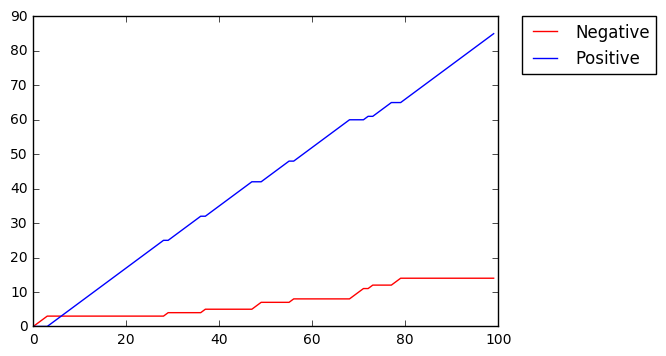

In [31]:
plot_ts((.5,.5,.8), "data/ts_feature_comparison_baseline.p")

**What changes do you notice in the agent's behavior when compared to the basic driving agent when random actions were always taken?** 
> Below are observations of the biggest changes noticable compared to the basic driving agent:
> * The biggest change that can be noticed is, the agent starts heading towards the destination even early in the process when almost no rules have been learned yet.
> * The agent stops at certain points, when needed but doesn't halt at a stop when the light is green and there is no interfering traffic.
> * The agent also learns that running over a red light is a bad choice and learns to either wait or pick a different route.
> * There are hardly any crashes that happen any more but it happens that even at a late stage that the agent makes mistakes.
> * In the beginning there are some negative outcomes but later on the positive results overweigh.
> * In fact the agent has a high success rate with only a few negative outcomes until later in the learning process.

**Why is this behavior occurring?**
> * It becomes obvious that the agent tries to maximize the actions that are producing the highest reward.
> * By adding a certain randomness to the algorithm (through a $\epsilon$ greedy implementation) we're taking into account to make mistakes but avoid getting stuck in a local minimum and learning a semi-optimal policy.
> * The agent seems to learn by her mistakes in the first iterations taking safer routes later on after she has learned.
> * Allowing out agent to explore 20 % of the time might make the difference in this setup.

We'll be taking these results as a first step towards a better policy and will try to maximize our agent's performance not only based on the success rate but also on other factors such as time.

## Improve the Q-Learning Driving Agent
The final task now is to enhance our driving agent so that, after sufficient training, the smartcab is able to reach the destination within the allotted time safely and efficiently. Parameters we are taking into account when it comes to tweaking the Q-Learning algorithm are

* the learning rate (alpha)
* the discount factor (gamma) and 
* the exploration rate (epsilon) 

All these parameters contribute to the driving agent’s ability to learn the best action for each state. 

**QUESTION: Report the different values for the parameters tuned in your basic implementation of Q-Learning.**

## Feature comparison
In order to find the best parameters for our agent and our environment, we are testing an array of feature combinations. At first let's take into consideration what each of these parameters stands for and what the effects of raising or lowering them could mean.

### Alpha (α)
Alpha (α) is also called the learning rate. Which means, this parameter defines how slow or fast our Q-Learning implementation learns. If we look at our implementation we see that α is being used to determine how much of the old q-value and how much of the new q-value is taken into consideration when learning the policy. The learning rate therefore determines to what extent the newly acquired information will override the old information. Speaking in extremes a factor of `0` will make the agent not learn anything, while an α value of `1` would make the agent consider only the most recent information.
Generally speaking, if the reward or transition function is stochastic (read random), then it could be wise to have α change over time and approaching zero at infinity. But we will try out an array of values in order to find the right configuration for our problem.

```python
    alpha = [.05, .3, .6, .9, 1]
```

### Gamma (γ)
The discount factor γ can be seen as the value of future rewards. This plays a major part in learning our correct policy. γ can be implemented as either a dynamic or static value depending on the environment the agent is acting in. γ determines how much the agent values future rewards vs. immediate rewards. Once again looking to extreme values a γ of `0` will make the agent only value immediate rewards and turn it into a short sighted agent. If γ is set to `1` on the other hand, the agent values future rewards equally much as current rewards. A factor approaching `1` will make the agent strive for a long-term high reward.

```python
    gamma = [.05, .3, .6, .9, 1]
```


### Exploration rate (ε)
The exploration rate determines how much randomness the agent allows for her actions. A high ε value in our case determines a low probability or randomness or in other words, the agent is more likely to choose the best action than a random action. This method of randomness ensures though that if enough trials are done, each action will be tried an infinite number of times. That's one of the properties for any Q-Learning agent to converge. It also ensures that optimal actions are discovered.

```python
    epsilon = [.05, .3, .6, .9, 1]
```

### Dynamic Parameters
As already discussed, it might be helpful to choose a parameter that evolves dynamically over the course of time. In order to implement this as a possible feature combination to choose from we take the sigmoid function and implement it with a positive $t$ where the function is supposed to move towards 1 and a negative $t$ where the function should move towards 0.

$$ S_{t} = \frac{1}{1 + e^{-t}} $$

The standard sigmoid curve looks like this:

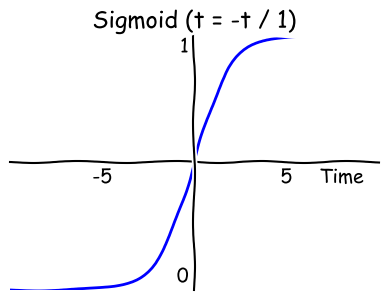

In [32]:
draw_sigmoid([1])

One problem that might occur is, that a sigmoid function tends to move towards 1 (or 0) rather quickly. As indicated above with a t of 5 (meaning after 5 steps) the function already reaches a value close to 1.
In order to cope up with this, we are adding two more slower evolving sigmoid functions to our ensemble. By dividing each t-step by 2 and 3, we manage to reach a more subtle development of the curve.

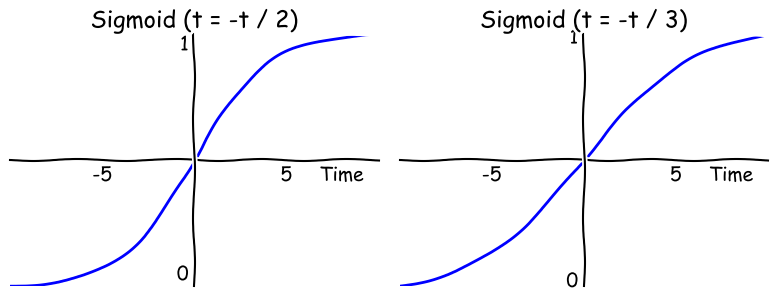

In [33]:
draw_sigmoid([2,3])

We are choosing the following setup for the dynamic parameters:
* alpha will start at ~1 and move towards 0
* gamma will start at ~0 and move towards 1
* epsilon will start at 0.5 and move towards 1

For each of the setups, we decide to progress in two different speeds: `[t, t/2]`

## Success metrics
In order to determine whether a combination is working great or should rather be discarded we need success metrics and a baseline to test against. From our initial testing on the basic agent with random actions we could already gauge her performance through the amount of times she reached her destination. Beating a 25.78 % success percentage should be the least we can do. In order to evaluate our combinations a little bit more in detail while keeping the most natural metric we are establishing some further metrics. For clarification here are all the numbers we are looking at:

#### Success vs. no success
One very important metric is, the question on how often an agent reaches her final destination. For each trial we will count the amount and calculate the mean over all test runs.

#### Steps
This metric intuitively counts the average steps it takes for a cab to reach its destination. The smaller the better. But this number is skewed through the random initialization of destination and cab. Averaged over all test runs this will still give us interesting insights about how quick a certain feature combination learns. 

#### Remaining Time vs. Time Alotted
In addition to the amount of successful trials (aka how often did the cab reach the destination in the alotted time) we also want to establish a metric that takes into consideration the ratio of the still remaining time and the deadline. Since the deadline is chosen based on the distance between the starting point of our cab and the location of the final destination, we are normalizing this term. We calculate this metric by dividing the remaining time at the end (which could also be 0 for unsuccessful trials) by the alotted time in the beginning and multiply it by 100 which gives us the ratio of time used vs. time given. We will print out: initial deadline (`deadline_start`), remaining time (`deadline_end`) and the ratio in between for comparability (creatively called ... *drum roll* ... `percentage`).

## Parameter Testing
Next we're going to observe the driving agent’s learning and smartcab’s success rate. We're also curious in how the success rate progresses over time as the agent learns. In order to find the best parameters we're going to use an exhaustive process that tries the mentioned parameters in their combinations.

### Overall Comparison Setup
The setup is as follows, each combination will run for 100 trials with enforced deadline and afterwards create a summary. These runs will cycle 5 times and all summaries will be averaged, calculating the success metrics. All information will be stored in a file:

> The comparison result files can be found in the folder `data/` the initial feature combination data is stored in `feature_comparison_qinit0_rinit0.csv` and `ts_feature_comparison_qinit0_rinit0.p` for the time-series data.

In [40]:
fc_q0r0 = pd.read_csv('data/feature_comparison_qinit0_rinit0.csv', sep = ';')
fc_q0r0.sort_values(['percentage', 'steps', 'success'], ascending=[False, True, False]).head(n=10)

,alpha,gamma,epsilon,no_success,success,steps,deadline_start,deadline_end,percentage
200,1.00,0.05,1.0,0.0,100.0,10.8,29.86,18.276,61.213835
298,99.00,0.05,1.0,0.4,99.6,11.8,29.18,17.696,60.637523
151,0.90,0.05,1.0,0.2,99.8,10.8,30.08,18.202,60.524823
235,1.00,9.00,1.0,1.8,98.2,13.8,30.05,18.152,60.442766
207,1.00,0.30,1.0,0.4,99.6,10.2,29.54,17.808,60.292098
11,0.05,0.30,1.0,0.8,99.2,8.2,29.85,17.986,60.256073
284,9.00,9.00,1.0,0.6,99.4,11.6,29.32,17.468,59.564776
333,99.00,9.00,1.0,0.6,99.4,8.8,29.75,17.718,59.518469
67,0.30,0.60,1.0,0.2,99.8,11.2,30.10,17.890,59.417939
53,0.30,0.05,1.0,0.6,99.4,12.6,29.19,17.302,59.350034


In [37]:
print 'Feature combinations with a 100% success rate: {}'.format(
    len(fc_q0r0[fc_q0r0['success'] == 100.0]))
print 'Smallest average step count for a success rate higher than 90 % was: {}'.format(min(fc_q0r0[fc_q0r0['success'] > 90.0]['steps']))

Feature combinations with a 100% success rate: 1
Smallest average step count for a success rate higher than 90 % was: 6.8


**For which set of parameters does the agent perform best? How well does the final driving agent perform?**

When we look at our first parameter combinations there are a couple very interesting takeaways:
* As mentioned above we have parameters that leave the game without even failing once to reach the destination.
* There were feature combinations that led to an average step count of 6.8 (while keeping a success rate higher than 90 %)
* In fact: the frontrunner based on the deadline_end vs deadline_start ratio percentage achieved its result with an average step count of 10.8 and over 61% of time still on the clock.

The Parameters:
* α: Based on these stats, alpha tends to work better with a higher (above .5) or dynamic setting that starts at ~1 and makes alpha move towards 0 over time.

* γ: For gamma, lower values tend to work better based on these metrics. This could have to do with the small playing field and the limited time given plus the steps it takes to reach the destination. In a game like this with our metrics, leaning towards immediate rewards seems to play out better for the agent.

* ε: The closer epsilon is to 1, the better the results get. It seems like agents that are exploring are being penalized for their wrong actions heavily based on our success definition. This could be connected to the environment, the success metrics we're using and the scope of the problem we are trying to learn. In a world where there is only limited time and a small playing field it might pay off to rather take the best learned action than to pick one at random.

Keeping in mind, that we want to make sure the algorithm always converges we would like to choose an ε that is smaller than 1 or never reaches 1. Taking this approach drops our success rate and percentage value down but it keeps an open mind towards larger settings and environments that are harder to move in. With this argument in mind, we're also discarding too small values for γ because we're looking for long-term effects in our training.

In [50]:
fc_q0r0[(fc_q0r0['epsilon'] != 1) & (fc_q0r0['gamma'] > .5)].sort_values(
    ['percentage', 'steps', 'success'], ascending=[False, True, False]).head(n=1)

,alpha,gamma,epsilon,no_success,success,steps,deadline_start,deadline_end,percentage
17,0.05,0.6,0.9,3.8,96.2,16.8,30.2,16.878,55.892645


Based on these rules, we're picking the following values:

```python
    alpha = 0.05
    gamma = 0.6
    epsilon = 0.9
```

When looking how this feature combination progressed over time, we can see that due to our insisted-on randomness, the agent seems to make mistakes and fail to succeed even late in the learning process. This effect however is far less severe then with our initial baseline and the parameter setup succeeds to improve it.

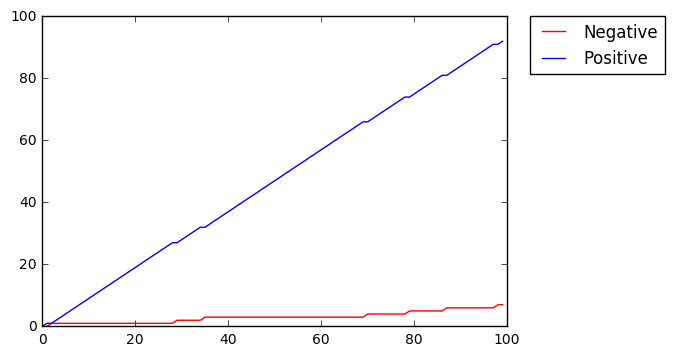

In [51]:
plot_ts((.05,.6,.9), "data/ts_feature_comparison_qinit0_rinit0.p")

## Further thoughts and Parameter Tuning
For additional exploration we want to take a step back and see, what else is out there that could make a difference for our agent. 

### More granular parameters
Looking at the distances in between parameters we chose, we could now go back and redo the feature combination with settings that are closer to the ones we chose. We could either substitute the parameters we have with parameters that are closer in range to the ones we picked or add them to the list.

Suggested changes would be:

```python
    alpha = [.05, .1, .2, 99]
    gamma = [.6, .7, .8, 99]
    epsilon = [.9, .95, .99]
```

In [55]:
fc_q0r1 = pd.read_csv('data/feature_comparison_granular.csv', sep = ';')
fc_q0r1.sort_values(['percentage', 'steps', 'success'], ascending=[False, True, False]).head(n=1)

,alpha,gamma,epsilon,no_success,success,steps,deadline_start,deadline_end,percentage
47,99.0,99.0,0.99,1.2,98.8,11.0,29.48,17.554,59.542556


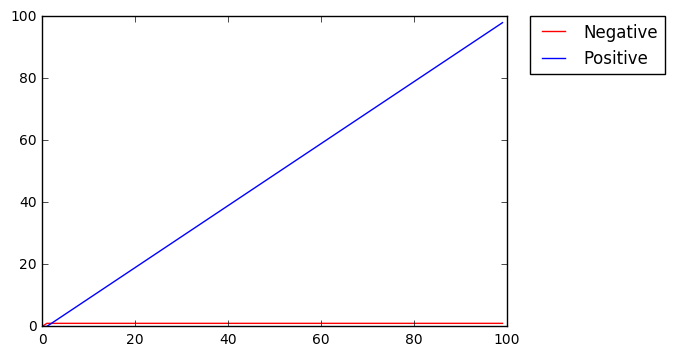

In [54]:
plot_ts((99,99,.99), 'data/ts_feature_comparison_granular.p')

By adding these values to the mix, we were able to create an even better result. Most of the improvement can be acounted to chosing an epsilon that is very close to 1. The ideal parameters to choose after this more in-depth analysis are:

```python
    alpha = sig(-t/2)
    gamma = sig(t/2)
    epsilon = .99
```

### Initial conditions
As mentioned before and shown in code we need to initialize states and their q_values that we haven't seen before. This move is inevitable because Q-Learning moves and learns in an iterative fashion. The decision on how to choose these initial conditions is often referred to as being 'arbitrary'. Further research suggested ways to map human behaviour better by resetting the initial condition for a certain action after experiencing it for the first time with its immediate reward. This approach seems to be consistent with human behaviour which was shown in repeated binary choice experiments. High initial values, also known as "optimistic initial conditions" can encourage exploration: no matter what action is selected, the update rule will cause it to have lower values than the other alternative, thus increasing their choice probability. 
In addition a high initial value tends to favor exploration in the beginning which is intuitively the right move to take when thrown into a new world.

Input from [Mark Lee @ University of Alberta](http://webdocs.cs.ualberta.ca/~sutton/book/ebook/node21.html)
and [The role of first impression in operant learning](http://psycnet.apa.org/?&fa=main.doiLanding&doi=10.1037/a0029550)

First we set the q values to a high initial value to encourage exploration in the beginning. This effect will be smaller though because our action values are being updated to the current reward value at a very early time. 

```python
    self.q_start = {None : 10, 'forward': 10, 'left': 10, 'right': 10}
    self.q_start_count = {None : 0, 'forward': 0, 'left': 0, 'right': 0}
```
`q_start_count` is basically just a counter keeping track if the action was already seen. If so, the counter is increased by one. When acting, the agent now checks if the action has been rewarded before and if so, sets the initial q value to its reward.

```python
    if (self.q_start_count[action] == 1):
        self.q_start[action] = reward
```

#### Action-Reward-Q-value Initialization
Given our parameters, we'll try to add the insights we gathered about human behavior when a state is unknown and the action's being taken for the first time adding the new state's reward to it.

In [60]:
fc_q0r0 = pd.read_csv('data/feature_comparison_qinit0_rinit1.csv', sep = ';')
fc_q0r0.sort_values(['percentage', 'steps', 'success'], ascending=[False, True, False])

,alpha,gamma,epsilon,no_success,success,steps,deadline_start,deadline_end,percentage
0,99,99,0.99,8.8,91.2,9.6,30.22,16.144,53.281207


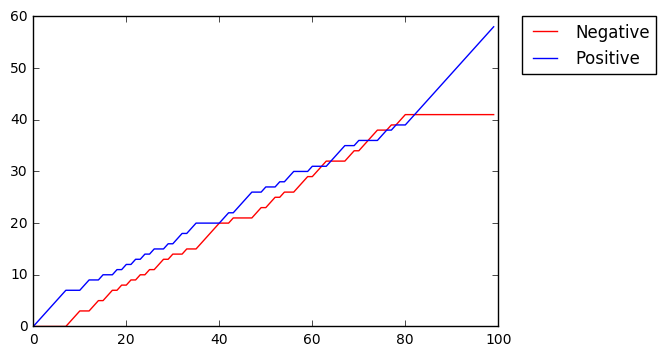

In [61]:
plot_ts((99,99,.99), 'data/ts_feature_comparison_qinit0_rinit1.p')

This approach seems to perform quite well in the beginning. However it might be possible that the agent learns some sub-optimal actions that are penalizing the learning process later on. In fact the agent only fully recovers after trial 80 and works without additional negative experiences.

#### High Initial Q-value
Let's see what a change in starting values will do the agents performance. At first we're changing only the initial state, bumping it up to 10 instead of a 0 initalization.

In [56]:
fc_q10r0 = pd.read_csv('data/feature_comparison_qinit10_rinit0.csv', sep = ';')
fc_q10r0.sort_values(['percentage', 'steps', 'success'], ascending=[False, True, False])

,alpha,gamma,epsilon,no_success,success,steps,deadline_start,deadline_end,percentage
0,99,99,0.99,3.0,97.0,7.8,30.14,17.948,59.553128


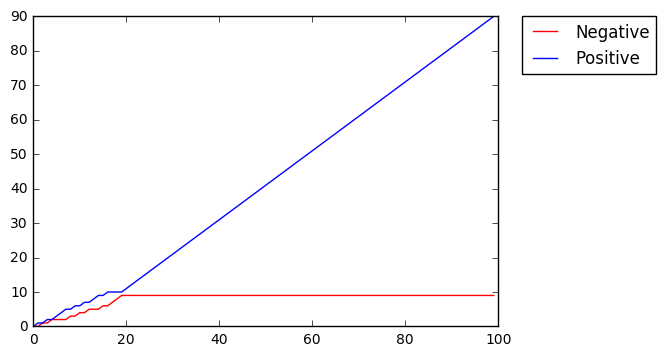

In [57]:
plot_ts((99,99,.99), 'data/ts_feature_comparison_qinit10_rinit0.p')

Due to additional exploration, our agent performs poorly in the first 20 trials but afterwards goes on without hesitation and with a clean slate. Even though the success rate dropped the performance in time and the reliability later down the road seem to improve our settings. The initial exploration seems to pay off later on.

After these additional experiments the best parameters we are choosing are alpha values that decrease slowly over time, gamma values that increase slowly over time, an epsilon value of .99 and a high initial Q-value to balance out the high epsilon value and encourage exploration in the beginning. With this setup the agent gets close to finding an optimal policy which is defined by reaching the destination in the minimum possible time without getting any penalties. The agent not only learns the best possible policy but it also learns to act in an optimal way, finding the final destination in the smallest amount of time. Our initial implementation already outperforms the random agent significantly. When adding feature comparison and tweaked initial q-values the performance even rises.

## Further Discussions
There are a couple points that are not part of this analysis but would be interesting to explore in the future:

* Randomness in action is a great way to keep the element of exploration but especially in a production or real-life setting this might be considered dangerous at a certain point.
* Implementation of a different $\epsilon$ strategy (i.e. softmax) might be worth trying out.
* Classifying rewards or giving them priority levels might make it possible to add a meta-layer or more context to the choice of action.
* Running the simulation for a longer time or adding additional agents would force difficult and dangerous actions more often and make the learning process better down the road. 

In [67]:
fc_final = pd.read_csv('data/feature_comparison_final.csv', sep = ';')
fc_final.sort_values(['percentage', 'steps', 'success'], ascending=[False, True, False])

,alpha,gamma,epsilon,no_success,success,steps,deadline_start,deadline_end,percentage
0,99,99,0.99,9.6,990.4,9.8,29.664,16.9934,57.284142


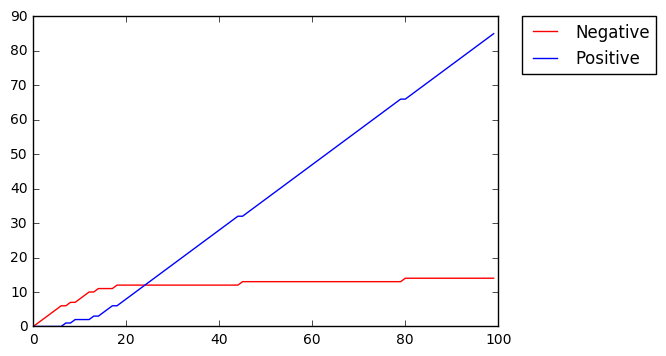

In [69]:
plot_ts((99,99,.99), 'data/ts_feature_comparison_final.p')